# ITAI 2373 – Final Project  
## NewsBot Intelligence System 2.0 – BBC News Dataset

This notebook extends the midterm NewsBot system into a more advanced, production-oriented NewsBot Intelligence System 2.0.  
Building on the previous pipeline (preprocessing, TF-IDF, POS, syntax, sentiment, classification, and NER), this final project adds:

- Advanced content analysis (improved classification, topic modeling, enhanced sentiment)
- Language understanding and generation (text summarization and semantic search)
- Multilingual intelligence (basic cross-language support via translation)
- A simple conversational interface for interactive exploration

The goal is to demonstrate how an end-to-end NLP system can support real-world news analysis workflows.


In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

import spacy

# Sentiment
from nltk.sentiment import SentimentIntensityAnalyzer

plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# spaCy model (run once; if error, run the commented line below)
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Install Kaggle API
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file")
uploaded = files.upload()

# Setup kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("✅ Kaggle API setup complete!")

# Download BBC News Dataset
!kaggle competitions download -c learn-ai-bbc

# Unzip the files
!unzip learn-ai-bbc.zip

# List the files to see what we have
!ls -la

# Load the dataset
import pandas as pd
import os

# Check what files are available
print("Available files:")
for file in os.listdir('.'):
    if file.endswith('.csv'):
        print(f"  - {file}")


Please upload your kaggle.json file


Saving kaggle.json to kaggle (1).json
✅ Kaggle API setup complete!
learn-ai-bbc.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  learn-ai-bbc.zip
replace BBC News Sample Solution.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace BBC News Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace BBC News Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
total 6880
drwxr-xr-x 1 root root    4096 Dec 10 17:34  .
drwxr-xr-x 1 root root    4096 Dec 10 17:26  ..
-rw-r--r-- 1 root root   10369 Dec  2  2019 'BBC News Sample Solution.csv'
-rw-r--r-- 1 root root 1712432 Dec  2  2019 'BBC News Test.csv'
-rw-r--r-- 1 root root 3351206 Dec  2  2019 'BBC News Train.csv'
drwxr-xr-x 4 root root    4096 Nov 20 14:30  .config
-rw-r--r-- 1 root root      64 Dec 10 17:34 'kaggle (1).json'
-rw-r--r-- 1 root root      64 Dec 10 17:29  kaggle.json
-rw-r--r-- 1 root root 1936538 Dec  2  2019  learn-ai-bbc.zip
drwxr-xr-x 1 root root    4096 Nov 20 14:30  samp

In [ ]:

df = pd.read_csv("BBC News Train.csv")

df = df.rename(columns={
    "Text": "content",
    "Category": "category"
})

df = df[["content", "category"]].dropna()

print(df.shape)
print(df["category"].value_counts())
df.head()


(1490, 2)
category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


,content,category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business


## 1. Core Pipeline Recap – Preprocessing, TF-IDF, and Baseline Classification

This section rebuilds the core midterm pipeline:
- text preprocessing
- TF-IDF feature extraction
- baseline multi-class classifiers

These components serve as the foundation for the advanced modules in NewsBot 2.0.


In [ ]:
import nltk
nltk.download('punkt_tab')
import re

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmas)

df["clean_text"] = df["content"].apply(preprocess_text)
df[["content", "clean_text", "category"]].head()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,content,clean_text,category
0,worldcom ex-boss launches defence lawyers defe...,worldcom bos launch defence lawyer defending f...,business
1,german business confidence slides german busin...,german business confidence slide german busine...,business
2,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizen majo...,business
3,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster better ...,tech
4,enron bosses in $168m payout eighteen former e...,enron boss payout eighteen former enron direct...,business


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["category"],
    test_size=0.2, random_state=42, stratify=df["category"]
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape


(1192, 5000)


=== LogisticRegression ===
Accuracy: 0.9697986577181208
               precision    recall  f1-score   support

     business       0.96      0.99      0.97        67
entertainment       0.98      0.98      0.98        55
     politics       0.96      0.95      0.95        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298


=== LinearSVC ===
Accuracy: 0.9630872483221476
               precision    recall  f1-score   support

     business       0.94      0.97      0.96        67
entertainment       0.96      1.00      0.98        55
     politics       0.98      0.93      0.95        55
        sport       0.97      1.00      0.99        69
         tech       0.96      0.90      0.93        52

     accuracy                           0.96       298
    macro 

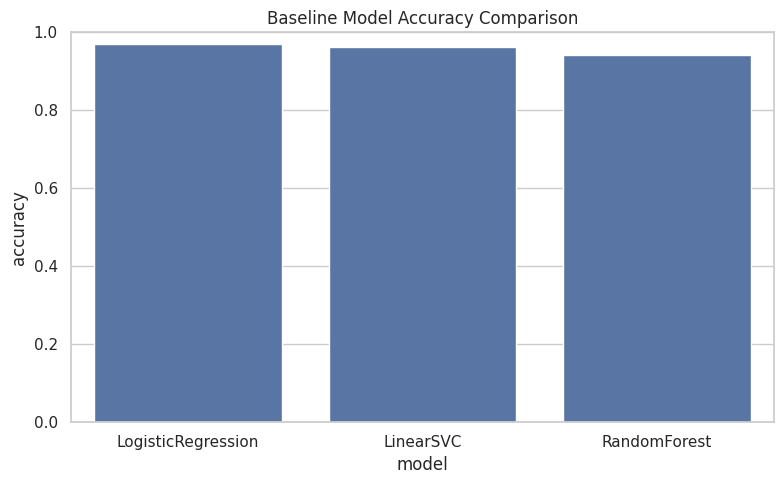

Best baseline model: LogisticRegression


In [ ]:
baseline_models = {
    "LogisticRegression": LogisticRegression(max_iter=300, n_jobs=-1),
    "LinearSVC": LinearSVC(),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    )
}

baseline_results = {}

for name, clf in baseline_models.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    baseline_results[name] = {
        "model": clf,
        "accuracy": acc,
        "report": classification_report(y_test, y_pred, output_dict=False)
    }
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

acc_df = pd.DataFrame({
    "model": list(baseline_results.keys()),
    "accuracy": [v["accuracy"] for v in baseline_results.values()]
})
sns.barplot(data=acc_df, x="model", y="accuracy")
plt.ylim(0, 1)
plt.title("Baseline Model Accuracy Comparison")
plt.tight_layout()
plt.show()

best_baseline_name = max(baseline_results, key=lambda k: baseline_results[k]["accuracy"])
best_baseline_model = baseline_results[best_baseline_name]["model"]
print("Best baseline model:", best_baseline_name)


## 2. Advanced Content Analysis Engine

### 2.1 Improved Classification (Hyperparameter Tuning)

Here I refine the baseline Logistic Regression classifier using a simple hyperparameter search to improve performance and robustness.


In [ ]:
param_grid = {
    "C": [0.5, 1.0, 2.0, 5.0],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

logreg = LogisticRegression(max_iter=500, n_jobs=-1)
grid = GridSearchCV(logreg, param_grid, cv=3, n_jobs=-1, verbose=0)
grid.fit(X_train_tfidf, y_train)

print("Best params:", grid.best_params_)
best_clf = grid.best_estimator_

y_pred_best = best_clf.predict(X_test_tfidf)
print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Best params: {'C': 2.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuned Logistic Regression Accuracy: 0.9697986577181208
               precision    recall  f1-score   support

     business       0.96      0.99      0.97        67
entertainment       0.98      0.98      0.98        55
     politics       0.96      0.95      0.95        55
        sport       0.99      1.00      0.99        69
         tech       0.96      0.92      0.94        52

     accuracy                           0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298



### 2.2 Topic Modeling with LDA

Next, I apply Latent Dirichlet Allocation (LDA) to discover latent topics in the BBC news corpus and inspect how topics align with categories.


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Use CountVectorizer for LDA
count_vectorizer = CountVectorizer(
    max_features=3000,
    stop_words='english',
    min_df=3
)

X_count = count_vectorizer.fit_transform(df["clean_text"])

n_topics = 6  # roughly corresponds to categories; you can adjust
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch"
)

lda.fit(X_count)

terms = np.array(count_vectorizer.get_feature_names_out())

def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[::-1][:n_top_words]
        top_terms = feature_names[top_idx]
        print(f"\nTopic {idx}:")
        print(", ".join(top_terms))

print_topics(lda, terms, n_top_words=12)



Topic 0:
said, year, england, ireland, growth, wale, sale, half, game, rate, france, time

Topic 1:
film, best, said, year, award, star, actor, director, oscar, british, time, new

Topic 2:
year, said, music, number, new, world, band, open, second, time, final, chart

Topic 3:
said, government, year, election, labour, say, minister, people, party, new, country, company

Topic 4:
said, people, user, computer, software, firm, net, use, site, mail, service, information

Topic 5:
game, said, mobile, phone, player, people, year, time, new, digital, music, like


In [ ]:
doc_topic_dist = lda.transform(X_count)
df_topics = pd.DataFrame(doc_topic_dist, columns=[f"topic_{i}" for i in range(n_topics)])
df_topics["category"] = df["category"].values

topic_means = df_topics.groupby("category").mean()
topic_means


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
category,,,,,,
business,0.232884,0.009992,0.040531,0.649670,0.043725,0.023199
entertainment,0.018050,0.539444,0.290759,0.076468,0.028358,0.046922
politics,0.017027,0.073546,0.014419,0.848605,0.031201,0.015202
sport,0.303959,0.151226,0.230232,0.028196,0.006426,0.279960
tech,0.012832,0.028302,0.031217,0.070731,0.487992,0.368925


### 2.3 Enhanced Sentiment Analysis

Here I reuse VADER to compute article-level sentiment scores and then:
- convert the continuous compound score into categorical labels (positive / neutral / negative),
- visualize how sentiment is distributed across news categories.

This type of aggregated sentiment view could feed directly into a media monitoring dashboard, helping analysts quickly see which categories have more positive or negative coverage.



In [ ]:
# Compute VADER compound sentiment for each article
def get_sentiment_score(text):
    if not isinstance(text, str):
        return 0.0
    scores = sia.polarity_scores(text)
    return scores["compound"]

df["sentiment_score"] = df["content"].apply(get_sentiment_score)

def label_sentiment(score, pos_th=0.05, neg_th=-0.05):
    if score >= pos_th:
        return "positive"
    elif score <= neg_th:
        return "negative"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment_score"].apply(label_sentiment)

print(df[["content", "category", "sentiment_score", "sentiment_label"]].head())


                                             content  category  \
0  worldcom ex-boss launches defence lawyers defe...  business   
1  german business confidence slides german busin...  business   
2  bbc poll indicates economic gloom citizens in ...  business   
3  lifestyle  governs mobile choice  faster  bett...      tech   
4  enron bosses in $168m payout eighteen former e...  business   

   sentiment_score sentiment_label  
0          -0.9701        negative  
1           0.7623        positive  
2          -0.9318        negative  
3           0.9554        positive  
4          -0.9486        negative  


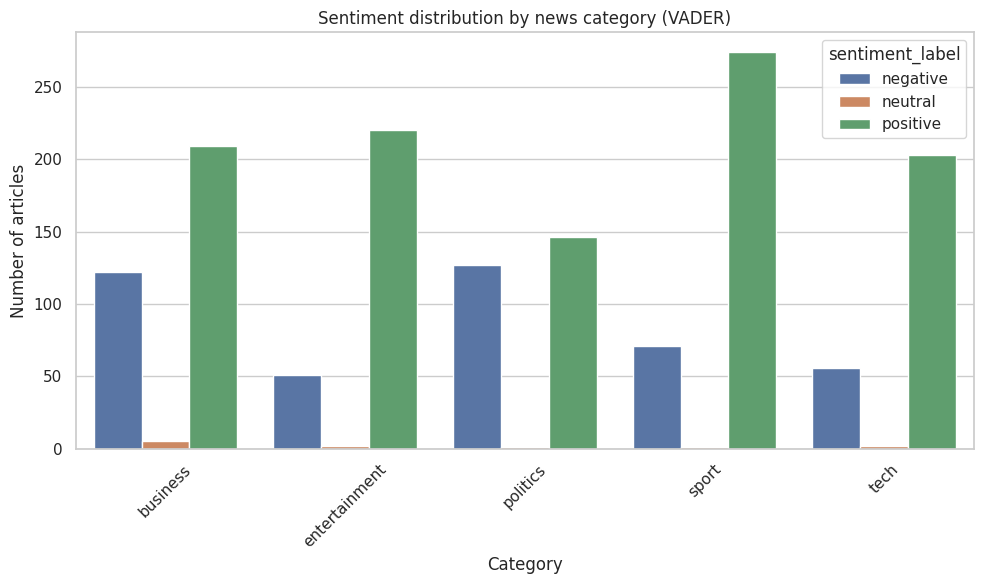

In [ ]:
# Aggregate sentiment distribution by category
sent_dist = (
    df.groupby(["category", "sentiment_label"])
      .size()
      .reset_index(name="count")
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=sent_dist,
    x="category",
    y="count",
    hue="sentiment_label"
)
plt.title("Sentiment distribution by news category (VADER)")
plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Average VADER sentiment score by category:
        category  sentiment_score
1  entertainment         0.599143
3          sport         0.554141
4           tech         0.523323
0       business         0.240397
2       politics         0.057763


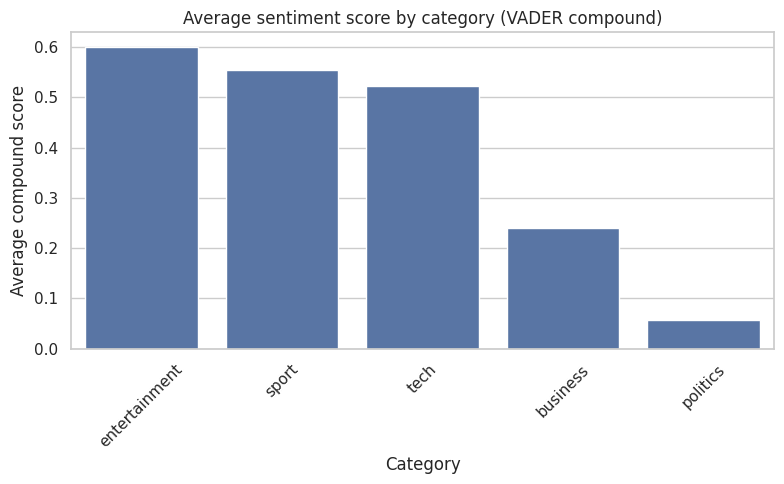

In [ ]:
# average sentiment score per category (for dashboard-style metric)
avg_sentiment = (
    df.groupby("category")["sentiment_score"]
      .mean()
      .reset_index()
      .sort_values("sentiment_score", ascending=False)
)

print("Average VADER sentiment score by category:")
print(avg_sentiment)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=avg_sentiment,
    x="category",
    y="sentiment_score"
)
plt.title("Average sentiment score by category (VADER compound)")
plt.xlabel("Category")
plt.ylabel("Average compound score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3. Language Understanding & Generation

### 3.1 Extractive Text Summarization

Here I implement a simple extractive summarization function that:
- splits an article into sentences,
- scores each sentence based on word frequencies,
- selects the top-scoring sentences as the summary.


In [ ]:
def build_word_freq(text):
    text = preprocess_text(text)
    tokens = text.split()
    freq = {}
    for t in tokens:
        freq[t] = freq.get(t, 0) + 1
    if not freq:
        return freq
    max_f = max(freq.values())
    for k in freq:
        freq[k] /= max_f
    return freq

def summarize_text(text, num_sentences=3):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""

    sentences = sent_tokenize(text)
    if len(sentences) <= num_sentences:
        return text

    word_freq = build_word_freq(text)
    if not word_freq:
        return "Summary unavailable."

    sentence_scores = {}
    for sent in sentences:
        tokens = preprocess_text(sent).split()
        if not tokens:
            continue
        score = sum(word_freq.get(t, 0) for t in tokens)
        sentence_scores[sent] = score

    ranked = sorted(sentence_scores.items(), key=lambda x: x[1], reverse=True)
    selected = [s for s, _ in ranked[:num_sentences]]
    return " ".join(selected)

# Demo on one article
sample_article = df["content"].iloc[0]
print("Original article:\n", sample_article[:800], "\n")
print("Generated summary:\n", summarize_text(sample_article, num_sentences=3))


Original article:
 worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday 

Generated summary:
 but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s a

### 3.2 Semantic Search over News Articles

Using the TF-IDF vectors, I implement a simple semantic search function that:
- encodes user queries using the same TF-IDF vectorizer,
- computes cosine similarity with all articles,
- returns the top-k most relevant articles.


In [ ]:
# Reuse tfidf and X_train_tfidf / X_test_tfidf? For search we use all docs.
tfidf_all = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_all_tfidf = tfidf_all.fit_transform(df["clean_text"])

def semantic_search(query, top_k=5):
    q_clean = preprocess_text(query)
    q_vec = tfidf_all.transform([q_clean])
    sims = cosine_similarity(q_vec, X_all_tfidf)[0]
    top_idx = sims.argsort()[::-1][:top_k]
    results = df.iloc[top_idx][["content", "category"]].copy()
    results["similarity"] = sims[top_idx]
    return results

# Demo search
search_results = semantic_search("stock market and business", top_k=3)
search_results


,content,category,similarity
1257,booming markets shed few tears the market for...,business,0.471901
604,standard life cuts policy bonuses standard lif...,business,0.337213
1061,karachi stocks hit historic high the karachi s...,business,0.227379


### Multilingual Intelligence

In [ ]:
!pip install googletrans==4.0.0rc1


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=b9eb2e34448d860eb7cc4f275f5c82cdc867984dcdd57893b9cac3b29b0ce745
  Stored in directory: /root/.cache/pip/wheels/95/0f/04/b17a72024b56a60e499ce1a6313d283ed5ba332407155bee03
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uninstalling hyperfram

In [ ]:
from googletrans import Translator
translator = Translator()

def translate_text(text, dest_lang="zh-cn"):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    try:
        result = translator.translate(text, dest=dest_lang)
        return result.text
    except Exception as e:
        print("Translation error:", e)
        return ""

def back_translate_to_english(text, src_lang="zh-cn"):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    try:
        result = translator.translate(text, src=src_lang, dest="en")
        return result.text
    except Exception as e:
        print("Back-translation error:", e)
        return ""


## 4. Multilingual Intelligence

Here I demonstrate basic multilingual support by:
- translating English articles into another language (e.g., Chinese),
- translating them back into English,
- and reusing the same sentiment and topic analysis pipeline.

This shows how the system could be extended to monitor non-English sources using translation as a bridge.


In [ ]:
sample = df["content"].iloc[10]
print("Original English article:\n", sample[:400], "\n")

zh_text = translate_text(sample, dest_lang="zh-cn")
print("Translated to Chinese:\n", zh_text[:400], "\n")

en_back = back_translate_to_english(zh_text, src_lang="zh-cn")
print("Back-translated to English:\n", en_back[:400], "\n")

print("Sentiment of original:", sia.polarity_scores(sample)["compound"])
print("Sentiment of back-translated:", sia.polarity_scores(en_back)["compound"])


Original English article:
 blair rejects iraq advice calls tony blair has rejected calls for the publication of advice on the legality of the iraq war amid growing calls for an investigation.  the prime minister told his monthly press conference the matter had been dealt with by the attorney general. earlier  conservative mp michael mates joined calls for a probe into claims lord goldsmith s statement to parliament was draw 

Translated to Chinese:
 布莱尔拒绝就伊拉克战争提出建议 托尼·布莱尔拒绝就伊拉克战争合法性发表建议，因为要求调查的呼声越来越高。总理在每月一次的新闻发布会上表示，此事已由总检察长处理。早些时候，保守派议员迈克尔·梅茨也呼吁对戈德史密斯勋爵向议会发表的声明是第10号起草的说法进行调查。布莱尔表示，这份声明是对戈德史密斯勋爵意见的公正总结。他（戈德史密斯勋爵）就是这么说的，我也是这么说的。布莱尔先生在唐宁街举行的每月新闻发布会上表示，他一次又一次地处理过这个问题。他拒绝回答有关该问题的进一步问题，称该问题已经处理过数十次，而且立场没有改变。戈德史密斯勋爵否认受到欺骗，并表示所写的文字是他的。政府拒绝发表他对战争合法性的建议，称此类文件一直处于保密状态。马茨是下议院情报和安全委员会的成员，也是战前情报巴特勒调查的一部分，他周五告诉英国广播公司：作为一般规则是正确的，但它不是绝对规则。他说，最近还曾在其他场合发表过有关查 

Back-translated to English:
 Blair refuses to give advice on Iraq war Tony Blair has refused to give advice on the legality of the Iraq war as 

## 5. Conversational Interface – Simple CLI NewsBot

This section implements a minimal conversational loop that allows a user to:
- search for relevant articles,
- request summaries,
- and inspect sentiment for specific items.

In a real deployment, this interface could be connected to a web app or chat platform.


In [ ]:
def show_article(idx, max_chars=400):
    row = df.iloc[idx]
    print(f"[Index {idx}] Category: {row['category']}")
    print(row["content"][:max_chars], "...\n")

def newsbot_cli():
    print("Welcome to NewsBot 2.0 CLI. Type 'help' for options, 'exit' to quit.")
    while True:
        user_input = input("\nYou: ").strip()
        if user_input.lower() in ["exit", "quit"]:
            print("NewsBot: Goodbye!")
            break
        if user_input.lower() == "help":
            print("NewsBot commands:")
            print("  search: <query>      - semantic search over news")
            print("  summary: <index>     - summarize article by index")
            print("  sentiment: <index>   - show VADER sentiment for article")
            print("  show: <index>        - display article snippet")
            continue

        if user_input.lower().startswith("search:"):
            query = user_input.split(":", 1)[1].strip()
            results = semantic_search(query, top_k=5)
            print(f"\nTop results for query: '{query}'")
            for i, (idx, row) in enumerate(results.iterrows()):
                print(f"\nResult {i+1} (index {idx}) – Category: {row['category']}, similarity={row['similarity']:.3f}")
                print(row["content"][:200], "...")
            continue

        if user_input.lower().startswith("summary:"):
            try:
                idx = int(user_input.split(":", 1)[1].strip())
                if idx < 0 or idx >= len(df):
                    print("Invalid index.")
                    continue
                print(f"\n[Summary for article index {idx}]")
                show_article(idx)
                print("Generated summary:")
                print(summarize_text(df.iloc[idx]["content"], num_sentences=3))
            except ValueError:
                print("Please provide a valid integer index.")
            continue

        if user_input.lower().startswith("sentiment:"):
            try:
                idx = int(user_input.split(":", 1)[1].strip())
                if idx < 0 or idx >= len(df):
                    print("Invalid index.")
                    continue
                text = df.iloc[idx]["content"]
                score = sia.polarity_scores(text)["compound"]
                print(f"\nSentiment for article index {idx}: compound={score:.3f}")
            except ValueError:
                print("Please provide a valid integer index.")
            continue

        if user_input.lower().startswith("show:"):
            try:
                idx = int(user_input.split(":", 1)[1].strip())
                if idx < 0 or idx >= len(df):
                    print("Invalid index.")
                    continue
                show_article(idx)
            except ValueError:
                print("Please provide a valid integer index.")
            continue

        print("Unrecognized command. Type 'help' for options.")

newsbot_cli()


Welcome to NewsBot 2.0 CLI. Type 'help' for options, 'exit' to quit.

You: help
NewsBot commands:
  search: <query>      - semantic search over news
  summary: <index>     - summarize article by index
  sentiment: <index>   - show VADER sentiment for article
  show: <index>        - display article snippet

You: summary: 1018

[Summary for article index 1018]
[Index 1018] Category: business
nortel in $300m profit revision telecoms equipment maker nortel networks has sharply revised downwards its profits for the 2003 fiscal year.  in a long-awaited filing  nortel said it had made $434m (£231m)  compared to the previously reported $732m. but the figures - revised after an audit which led to the sacking of the canadian firm s chief - showed revenue was about 4% higher than first thought ...

Generated summary:
nortel in $300m profit revision telecoms equipment maker nortel networks has sharply revised downwards its profits for the 2003 fiscal year. nortel s head frank dunn and two other e